# Generate Synthetic data

### Import required packages

In [1]:
import numpy as np 
import pandas as pd
import os
import matplotlib.pyplot as plt

## Define the generator

In [2]:

np.random.seed(42)

def generate_samples(n=5, beta=0, gamma=0, delta=0.5, eta = 2):

    # Generate root nodes
    UG = np.random.binomial(1, 0.5, n).astype(int)
    UA = np.random.gamma(10,3.5, n)
    
    G = UG
    A = -35 + UA

    # Generate covariates
    UE = np.random.normal(0, 0.25, n)
    UI = np.random.normal(0, 4, n)
    US = np.random.normal(0, 5, n)
    
    E = -0.5 + sigmoid(-1 + 0.5 * G + sigmoid(0.1 * A) + UE)
    I = -4 + 0.1 * (A + 35) + 2 * G + G * E + UI
    S = -4 + 1.5 * np.where(I > 0, I, 0) + US

    # Generate treatment
    UL = np.random.normal(0, 10, n)
    UD = np.random.normal(0, 9, n)
    
    L = 1 + 0.01 * (A - 5) * (5 - A) + 2*(1 - G) + beta * S + UL
    D = -1 + 0.1 * A + 3 * (1 - G) + L + UD
    
    UY = np.random.normal(0,eta)
    
    # Generate outcome
    alpha = np.where((I > 0) & (S > 0), 1, -1)
    Y = ((sigmoid(delta*(-L - D) + 0.3 * (I + S + alpha*I*S))) >= 0.5 + gamma * (1 - G)).astype(int)
    Y = ((sigmoid(delta*(-L - D) + 0.3 * (I + S + alpha*I*S)+ UY * gamma * (1 - G))) >= 0.5 ).astype(int)



    U = np.vstack([UG,UA,UE,UI,US,UL,UD]).transpose(1,0)
    X = np.vstack([G, A, E, I, S, L, D]).transpose(1, 0)
    Y = np.asarray(Y).reshape(-1, 1)
    return X, Y, U

In [3]:
beta = 0
gamma = 0
delta = 0.5
eta = 2
n= 5000

In [4]:
os.mkdir(f"beta_{beta}_gamma{gamma}_delta{delta}")

In [5]:
# Sigmoid function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [6]:
# Generate 5000 samples of Y
X_factuals,Y_factuals,U_factuals = generate_samples(n=n, beta = beta,gamma = gamma, delta = delta)

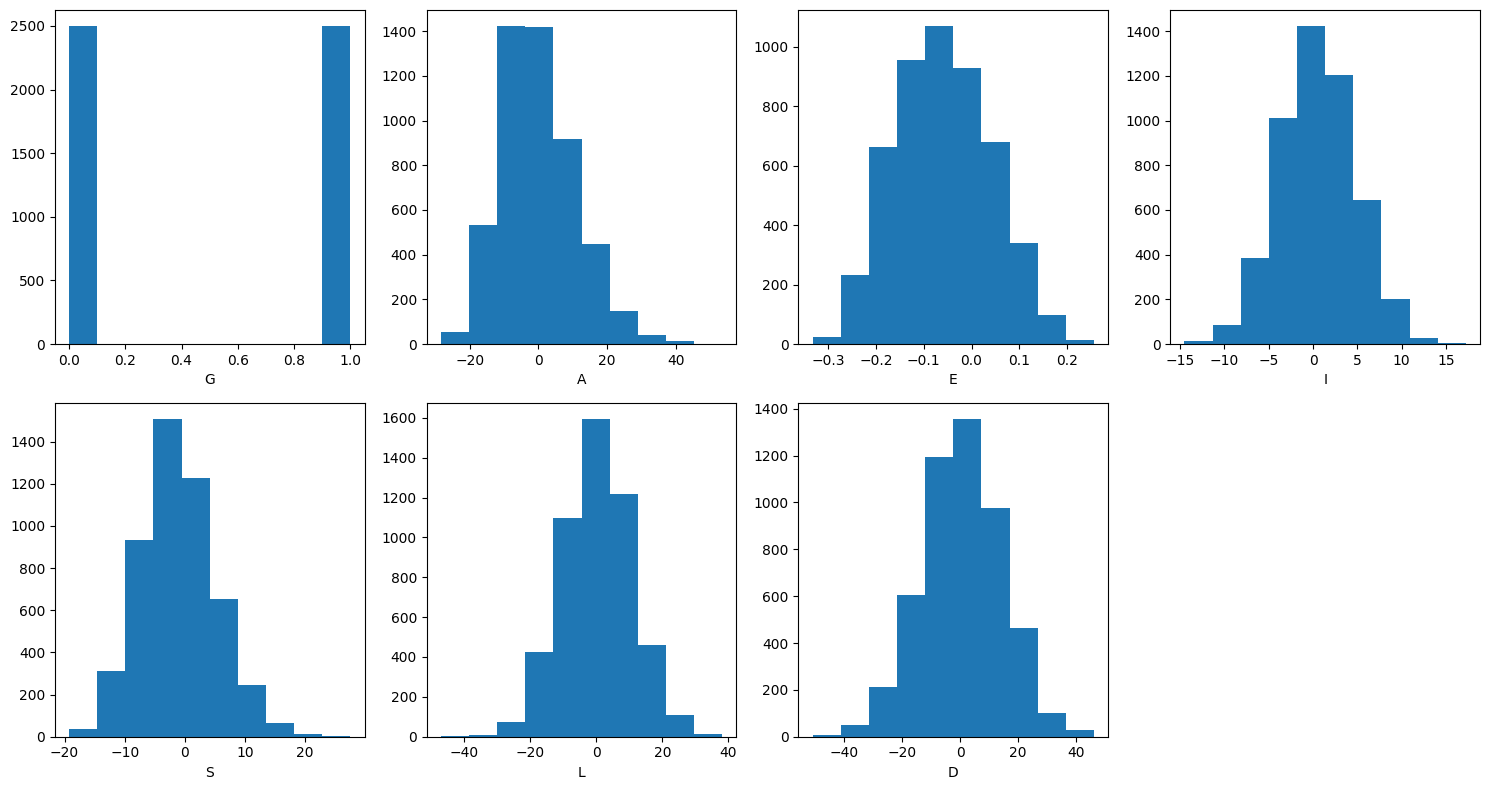

In [7]:
rows = 2
cols = 4

names_cols = ['G','A','E','I','S','L','D']

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(15, 8))
axes = axes.flatten()

for i in range(7):
    axes[i].hist(X_factuals[:, i])
    axes[i].set_xlabel(names_cols[i])

for j in range(7, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()

plt.show()

In [8]:
factuals = np.concatenate([X_factuals, Y_factuals], axis=1) # D_F 

In [9]:
df = pd.DataFrame(U_factuals, columns=[['UG','UA','UE','UI','US','UL','UD']])
df.to_csv(f"beta_{beta}_gamma{gamma}_delta{delta}/U.csv",index=False, float_format='%.2g')

## Computing the Full Counterfactual do(s^{CF})  -- Y^{CF}


In [10]:
def compute_fullcounterfactual(U, n=5,beta=0, gamma=0, delta=0.5):
    # Generate root nodes

    G = (1-U[:,0]).astype(int)
    A = -35 + U[:,1]

    #covariates
    E = -0.5 + sigmoid(-1 + 0.5 * G + sigmoid(0.1 * A) + U[:,2])
    I = -4 + 0.1 * (A + 35) + 2 * G + G * E + U[:,3]
    S = -4 + 1.5 * np.where(I > 0, I, 0) + U[:,4]

    # Generate treatment
    L = 1 + 0.01 * (A - 5) * (5 - A) + (1 - G) + beta * S + U[:,5]
    D = -1 + 0.1 * A + 2 * (1 - G) + L + U[:,6]

    # Generate outcome
    Y = ((sigmoid(delta*(-L - D) + 0.3 * (I + S))) >= 0.5 + gamma * (1 - G)).astype(int)
    

    X = np.vstack([G, A, E, I, S, L, D]).transpose(1, 0)
    Y = np.asarray(Y).reshape(-1, 1)        #Y^{CF}
      
    return X, Y

In [11]:
X_CF, Y_CF = compute_fullcounterfactual(U_factuals,beta = beta,gamma = gamma, delta = delta)  #computing counterfactuals 
counterfactuals = np.concatenate([X_CF, Y_CF], axis=1) # D_F 
print (counterfactuals.shape)

(5000, 8)


## Computing TTD with change in only treatment Z = Z^{CF}, X^F, S^F


In [12]:
def compute_TTD(X, X_CF, n=5, beta=0, gamma=0, delta=0.5):
    # Generate root nodes

    G = X[:,0]
    A = X[:,1]

    #covariates
    E = X[:,2]
    I = X[:,3]
    S = X[:,4]

    # Z^{CF}
    L = X_CF[:,5]   
    D = X_CF[:,6]

    # Generate outcome
    Y = ((sigmoid(delta*(-L - D) + 0.3 * (I + S))) >= 0.5 + gamma * (1 - G)).astype(int)

    Y = np.asarray(Y).reshape(-1, 1)        #Y^{CF}
    
    return Y

In [13]:
Y_TTD = compute_TTD(X_factuals, X_CF, beta = beta,gamma = gamma, delta = delta)  #ensure you are giving Z counterfactuals 

## Computing Path-specific S^CF, X^F, Z=Z^F


In [14]:
def compute_PSDL(X, X_CF, n=5, beta=0, gamma=0, delta=0.5):
    # Generate root nodes

    G = X_CF[:,0]
    A = X[:,1]

    #covariates
    E = X[:,2]
    I = X[:,3]
    S = X[:,4]

    # Z^{CF}
    L = X[:,5]
    D = X[:,6]

    # Generate outcome
    Y = ((sigmoid(delta*(-L - D) + 0.3 * (I + S))) >= 0.5 + gamma * (1 - G)).astype(int)

    Y = np.asarray(Y).reshape(-1, 1)        #Y^{CF}
    
    return Y

In [15]:
Y_PSDL = compute_PSDL(X_factuals, X_CF, beta = beta,gamma = gamma, delta = delta)   

In [16]:
# Z_PS = Fz(S^{CF}, X^{F})

def compute_PSDT(X, X_CF, U, n=5,beta=0, gamma=0, delta=0.5):
    # Generate root nodes

    G = X_CF[:,0]
    A = X[:,1]

    #covariates
    E = X[:,2]
    I = X[:,3]
    S = X[:,4]

    # Z^{CF}
    L = 1 + 0.01 * (A - 5) * (5 - A) + (1 - G) + beta * S + U[:,5]
    D = -1 + 0.1 * A + 2 * (1 - G) + L + U[:,6]

    # Generate outcome
    Y = ((sigmoid(delta*(-L - D) + 0.3 * (I + S))) >= 0.5 + gamma * (1 - G)).astype(int)

    Y = np.asarray(Y).reshape(-1, 1)       
    
    return Y

In [17]:
Y_PSDT = compute_PSDT(X_factuals, X_CF, U_factuals,beta = beta, gamma = gamma, delta = delta) 

In [18]:
df = pd.DataFrame(factuals, columns=[['Gender','Age','Education','Income','Savings','Loan_amt','Duration','Y']])
df.to_csv(f"beta_{beta}_gamma{gamma}_delta{delta}/data.csv", index=False,float_format='%.3g')

In [19]:
extras = np.concatenate([counterfactuals, Y_TTD,Y_PSDL, Y_PSDT], axis=1)

In [20]:
df = pd.DataFrame(extras, columns=[['G_CF','A_CF','E_CF','I_CF','S_CF','L_CF','D_CF','Y_CF','Y_TTD','Y_PDSL','Y_PSDT']])
df.to_csv(f"beta_{beta}_gamma{gamma}_delta{delta}/meta.csv", index=False, float_format='%.3g')